# Importing Libraries

In [1]:
# Import necessary libraries
from abc import ABC, abstractmethod 
import random
import numpy as np 
import matplotlib.pyplot as plt 
import csv
from scipy.stats import beta

Below you can see initialized values of 20,000 trials with Bandit Rewards [1,2,3,4]. The below probabilities are taken arbitrary, just so that 0.15+0.2+0.35+0.3 = 1 (100%). You can change the probabilities and same way run the code for different bandit probabilities. Bandit Rewards are later going to be used for defining the reward of each bandit after the trials.

In [2]:
NUM_TRIALS = 20000  # Number of trials for experiments
EPS = 0.1  # Epsilon value for Epsilon-Greedy algorithm
BANDIT_PROBABILITIES = [0.15, 0.2, 0.35, 0.3]  # Probabilities of success for different bandits
BANDIT_REWARDS = [1,2,3,4] # Rewards given from each Bandit after winning

# Bandit Class

The following class includes initialization, representation, pulling, updating, experiment and report functions. Since Badnit is a base class, the below inheriting classes should have the same function/attributes as Bandit has.

- \__init__\(self, p): Initializes a bandit with a given probability of success (p).
- \__repr__\(self): Provides a string representation of the bandit.
- pull(self): Simulates a pull of the bandit, returning True or False based on success.
- update(self, x): Updates the bandit's internal estimate of success probability based on the outcome x.
- experiment(self): An abstract method for running an experiment (to be implemented in derived classes).
- report(self): An abstract method for reporting results (to be implemented in derived classes).

In [3]:
class Bandit(ABC):

    def __init__(self, p):
        self.p = p  # Probability of success for the bandit
        self.p_estimate = 0  # Estimated probability of success
        self.N = 0  # Number of times the bandit has been pulled

    def __repr__(self):
        return 'An Arm with {} Win Rate'.format(self.p)
    
    #inheritance function, same for both algorithms
    def pull(self):
        return np.random.random() < self.p

    
    def update(self, x):
        self.N += 1
        self.p_estimate = ((self.N - 1) * self.p_estimate + x) / self.N

    
    def experiment(self):
        pass

    def report(self):
        # store data in csv
        # print average reward (use f strings to make it informative)
        # print average regret (use f strings to make it informative)
        pass

# Thompson Sampling Class

The ThompsonSampling class is a concrete implementation of a bandit algorithm. It uses the Thompson Sampling algorithm to solve the multi-armed bandit problem. It includes methods for:

Bandit probabilities are initialized using BANDIT_PROBABILITIES.
revising their estimates and taking samples from every bandit.
tracking the bandit populations over time.
experimenting with a predetermined quantity of trials.
reporting the outcomes, preserving data in a CSV file, and reporting total payouts and the win rates.

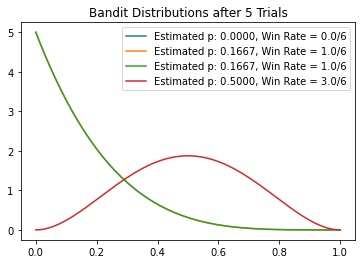

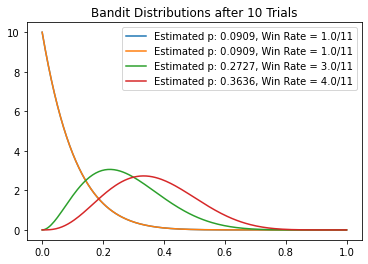

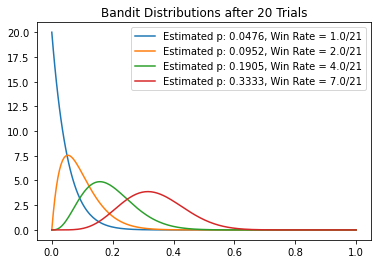

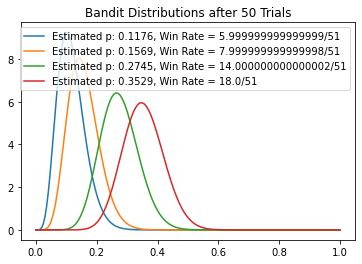

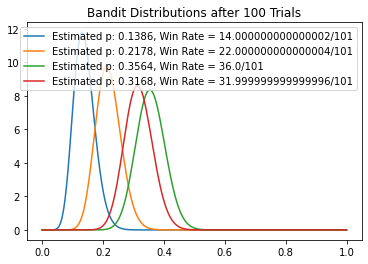

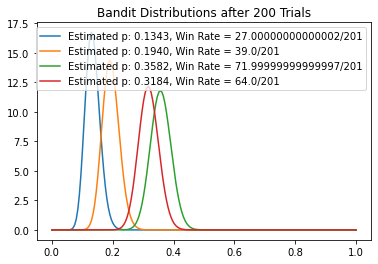

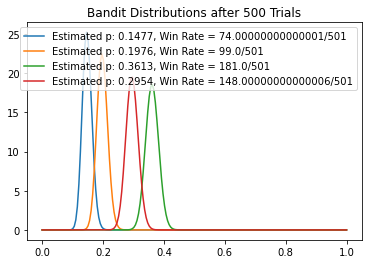

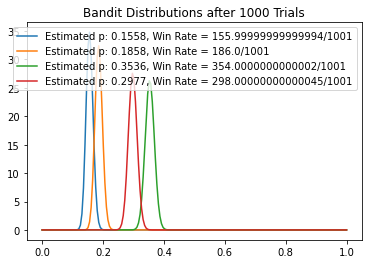

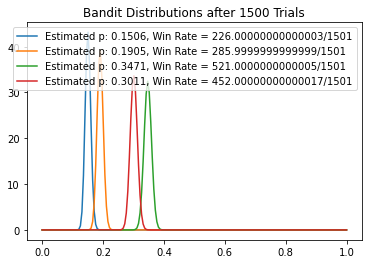

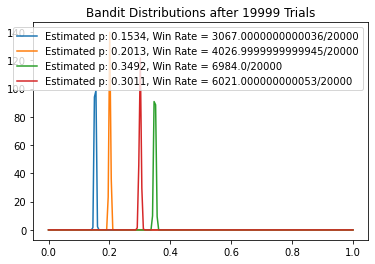

Total Reward Earned: 6986.0
Overall Win Rate: 0.3493
# of Times Selected Each Bandit: [20000, 20000, 20000, 20000]


In [4]:
# Thompson Sampling class
class ThompsonSampling(Bandit):
    def __init__(self, probabilities):
        self.bandits = [Bandit(p) for p in probabilities] # Create bandits with given success probabilities
        
    def __repr__(self):
        return "Thompson Sampling"

    def sample(self):
        return [bandit.pull() for bandit in self.bandits] # Simulate pulling all bandits

    def update(self, results):  # Update bandit success information
        for i, result in enumerate(results):
            self.bandits[i].update(result)

    def plot(self, trial): # Plotting the progress by the Time 
        x = np.linspace(0, 1, 200)
        for bandit in self.bandits:
            y = beta.pdf(x, bandit.p_estimate * bandit.N, (1 - bandit.p_estimate) * bandit.N)
            plt.plot(x, y, label=f"Estimated p: {bandit.p_estimate:.4f}, Win Rate = {bandit.p_estimate * bandit.N}/{bandit.N}")
        plt.title(f"Bandit Distributions after {trial} Trials")
        plt.legend()
        plt.show()

    def experiment(self, num_trials):
        sample_points = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, num_trials - 1]
        rewards = np.zeros(num_trials)

        for i in range(num_trials):
            results = self.sample()
            self.update(results)

            if i in sample_points:
                self.plot(i)

            rewards[i] = results[np.argmax([bandit.p_estimate for bandit in self.bandits])]

        return rewards

    def report(self, num_trials):
        rewards = self.experiment(num_trials)
        cumulative_rewards = np.cumsum(rewards)
        win_rates = cumulative_rewards / (np.arange(num_trials) + 1)

        print("Total Reward Earned:", rewards.sum())
        print("Overall Win Rate:", rewards.sum() / num_trials)
        print("# of Times Selected Each Bandit:", [bandit.N for bandit in self.bandits])

        # Save data to a CSV file, including rewards associated with each trial
        with open('thompson_sampling_results.csv', 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Trial', 'Reward', 'Cumulative Reward', 'Win Rate', 'Actual Reward'])
            for i in range(num_trials):
                actual_reward = BANDIT_REWARDS[i % len(BANDIT_REWARDS)]
                csv_writer.writerow([i + 1, rewards[i], cumulative_rewards[i], win_rates[i], actual_reward])


# Running the experiment and reporting the results
thompson_sampling = ThompsonSampling(BANDIT_PROBABILITIES)
thompson_sampling.report(NUM_TRIALS)


From the above graph, after 19999 trials, it is visible how the green curve is the most right oriented (Bandit 3). This means that the values from the green, 3rd, bandit are more probable to be greater out of all. Thus, 3rd bandit provides higher probabilities, meaning that it is more beneficial to choose. 

- Total Reward Earned: 6986.0 -> he sum of rewards obtained from pulling the bandits over the course of the experiment
- Overall Win Rate: 0.3493 -> on average, the agent received a reward of 0.3493 for each trial



\**NUMBERS and COLORS MENTIONED ABOVE ARE A SUBJECT TO CHANGE (coming from the fact of randomness in the algorithms).**

# Epsillion-Greedy Class

The EpsilonGreedy class is another concrete implementation of a bandit algorithm, specifically using the Epsilon-Greedy algorithm. It includes methods for:

Initializing bandits with success probabilities and setting an exploration rate (epsilon).
Decaying the epsilon value over time.
Choosing a bandit to pull based on the epsilon-greedy strategy.
Running an experiment with a specified number of trials.
Reporting the results, similar to the ThompsonSampling class.


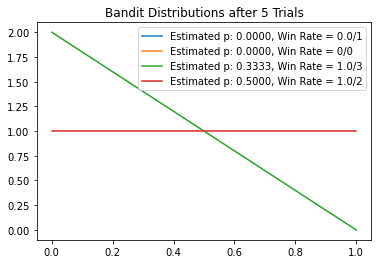

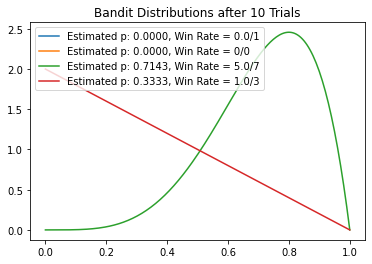

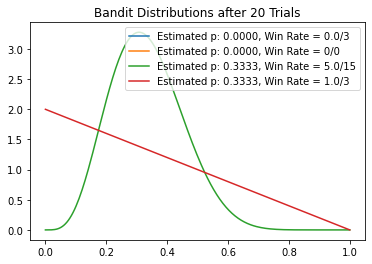

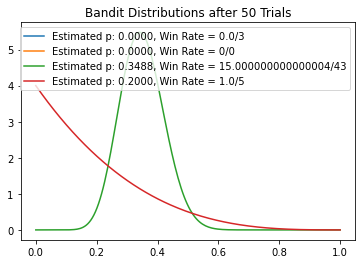

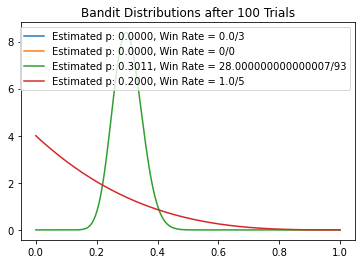

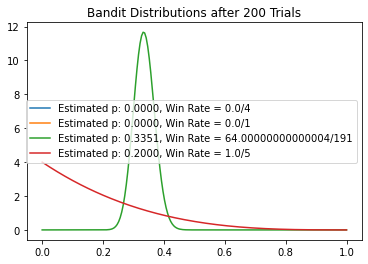

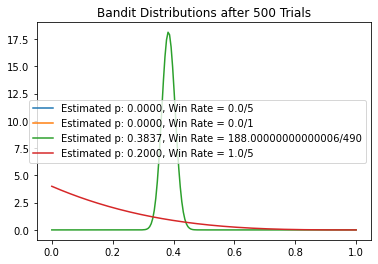

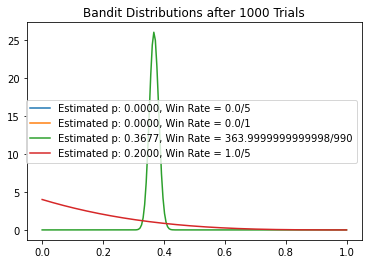

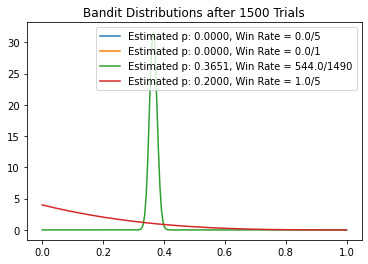

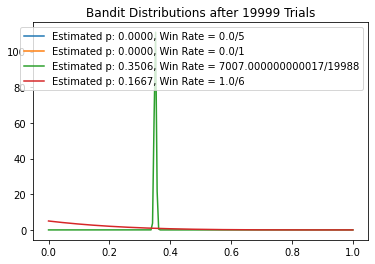

Total Reward Earned: 7008.0
Overall Win Rate: 0.3504
# of Times Selected Each Bandit: [5, 1, 19988, 6]


In [5]:
class EpsilonGreedy(Bandit):
    random.seed(42)
    def __init__(self, probabilities, epsilon):
        super().__init__(max(probabilities))  # Create a bandit with the highest probability
        self.bandits = [Bandit(p) for p in probabilities]  # Create bandits with given success probabilities
        self.epsilon = epsilon  # Epsilon value for exploration
        self.t = 0  # Initialize time step t
        
        
    def decay_epsilon(self):
        self.epsilon = 1 / (self.t+1 )  # Decay epsilon as time progresses

    def choose_bandit(self): 
        if np.random.random() < self.epsilon:
            return np.random.randint(len(self.bandits)) # Choose a random bandit for exploration
        else:
            return np.argmax([bandit.p_estimate for bandit in self.bandits])

    def experiment(self, num_trials):
        sample_points = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, num_trials - 1]
        rewards = np.zeros(num_trials)

        for i in range(num_trials):
            self.decay_epsilon()  # Decay epsilon
            self.t += 1  # Increment the time step
            chosen_bandit = self.choose_bandit()
            x = self.bandits[chosen_bandit].pull()  # Simulate pulling the chosen bandit
            self.bandits[chosen_bandit].update(x)  # Update bandit success information
            rewards[i] = x  # Record the reward

            if i in sample_points:
                self.plot(i)  # Visualize bandit distributions

        return rewards

    def report(self, num_trials):
        rewards = self.experiment(num_trials)
        cumulative_rewards = np.cumsum(rewards)
        win_rates = cumulative_rewards / (np.arange(num_trials) + 1)

        print("Total Reward Earned:", rewards.sum())
        print("Overall Win Rate:", rewards.sum() / num_trials)
        print("# of Times Selected Each Bandit:", [bandit.N for bandit in self.bandits])

        # Save data to a CSV file, including rewards associated with each trial
        with open('epsillion_greedy_results.csv', 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Trial', 'Reward', 'Cumulative Reward', 'Win Rate', 'Actual Reward'])
            for i in range(num_trials):
                actual_reward = BANDIT_REWARDS[i % len(BANDIT_REWARDS)]
                csv_writer.writerow([i + 1, rewards[i], cumulative_rewards[i], win_rates[i], actual_reward])

    def plot(self, trial):
        x = np.linspace(0, 1, 200)
        for bandit in self.bandits:
            y = beta.pdf(x, bandit.p_estimate * bandit.N, (1 - bandit.p_estimate) * bandit.N)
            plt.plot(x, y, label=f"Estimated p: {bandit.p_estimate:.4f}, Win Rate = {bandit.p_estimate * bandit.N}/{bandit.N}")
        plt.title(f"Bandit Distributions after {trial} Trials")
        plt.legend()
        plt.show()



# Running the experiment and reporting the results
epsilon_greedy = EpsilonGreedy(BANDIT_PROBABILITIES, EPS)
epsilon_greedy.report(NUM_TRIALS)


As from the Thompson Sampling graph, same way here, green curve wins the race. The red is more of the left side and converges to 0 with less probabilities for it's values to be chosen, while orange and blue graphs are not showing, because of the lack of participation. Out of the curves, green one is more righter, thus more probable to be chosen. Thus, Bandit 3 is more beneficial to be chosen. Total Rewards of the graph is 7008, which is the sum of rewards obtained from pulling the bandits over the course of the experiment. Overall win rate is 0.3504, which means that on average, the agent received a reward of 0.3504 for each trial. And out of all trials, you can see that 19988 trials were distributed to the winning bandit arm.



\**NUMBERS and COLORS MENTIONED ABOVE ARE A SUBJECT TO CHANGE (coming from the fact of randomness in the algorithms).**

# Visualize, Comparison

The code defines a comparison function that:

Creates instances of both the Thompson Sampling and Epsilon-Greedy algorithms.
Runs both algorithms for the same number of trials.
Visualizes the performance of each bandit.
Compares cumulative rewards and cumulative regrets of both algorithms.
A Visualization class is used to create plots for performance comparison. It provides methods for plotting bandit performance and cumulative rewards/regrets.

Finally, the comparison function is called to run the experiments and visualize the results.


In [6]:
def comparison():
    # Create instances of the two algorithms
    thompson_sampling = ThompsonSampling(BANDIT_PROBABILITIES)
    epsilon_greedy = EpsilonGreedy(BANDIT_PROBABILITIES, EPS)
    
    # Run both algorithms for the same number of trials
    num_trials = 20000
    thompson_sampling_rewards = thompson_sampling.experiment(num_trials)
    epsilon_greedy_rewards = epsilon_greedy.experiment(num_trials)
    
    # Create an instance of the Visualization class
    vis = Visualization()
    
    # Visualize the performance of each bandit
    vis.plot1(thompson_sampling.bandits, epsilon_greedy.bandits)
    
    # Compare cumulative rewards and cumulative regrets of E-greedy and Thompson Sampling
    vis.plot2(thompson_sampling_rewards, epsilon_greedy_rewards)

class Visualization():
    def plot1(self, thompson_bandits, epsilon_bandits):
        # Visualize the performance of each bandit: linear and log
        for i, (t_bandit, e_bandit) in enumerate(zip(thompson_bandits, epsilon_bandits)):
            x = np.arange(1, t_bandit.N + 1)
            plt.figure(figsize=(12, 4))
            
            # Linear plot
            plt.subplot(1, 2, 1)
            plt.plot(x, np.cumsum(t_bandit.pull()) / x, label="Thompson Sampling")
            plt.plot(x, np.cumsum(e_bandit.pull()) / x, label="Epsilon-Greedy")
            plt.xlabel("Trials")
            plt.ylabel("Average Reward")
            plt.title(f"Bandit {i + 1} Performance (Linear)")
            plt.legend()

            # Log plot
            plt.subplot(1, 2, 2)
            plt.semilogx(x, np.cumsum(t_bandit.pull()) / x, label="Thompson Sampling")
            plt.semilogx(x, np.cumsum(e_bandit.pull()) / x, label="Epsilon-Greedy")
            plt.xlabel("Trials (Log Scale)")
            plt.ylabel("Average Reward")
            plt.title(f"Bandit {i + 1} Performance (Log)")
            plt.legend()

            plt.show()

    def plot2(self, thompson_rewards, epsilon_rewards):
        # Compare E-greedy and Thompson Sampling cumulative rewards and cumulative regrets
        x = np.arange(len(thompson_rewards))
        thompson_cumulative_rewards = np.cumsum(thompson_rewards)
        epsilon_cumulative_rewards = np.cumsum(epsilon_rewards)
        thompson_regrets = np.max(BANDIT_PROBABILITIES) - thompson_cumulative_rewards
        epsilon_regrets = np.max(BANDIT_PROBABILITIES) - epsilon_cumulative_rewards
        
        plt.figure(figsize=(12, 4))
        
        # Cumulative Rewards
        plt.subplot(1, 2, 1)
        plt.plot(x, thompson_cumulative_rewards, label="Thompson Sampling")
        plt.plot(x, epsilon_cumulative_rewards, label="Epsilon-Greedy")
        plt.xlabel("Number of Trials")
        plt.ylabel("Cumulative Rewards")
        plt.title("Cumulative Rewards Comparison")
        plt.legend()
        
        # Cumulative Regrets
        plt.subplot(1, 2, 2)
        plt.plot(x, thompson_regrets, label="Thompson Sampling")
        plt.plot(x, epsilon_regrets, label="Epsilon-Greedy")
        plt.xlabel("Number of Trials")
        plt.ylabel("Cumulative Regrets")
        plt.title("Cumulative Regrets Comparison")
        plt.legend()

        plt.show()


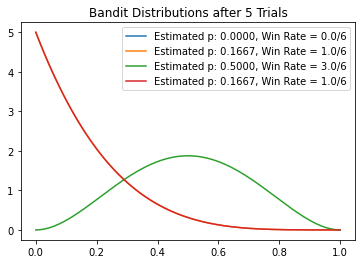

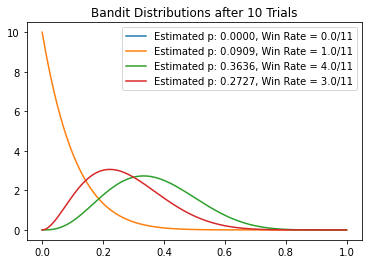

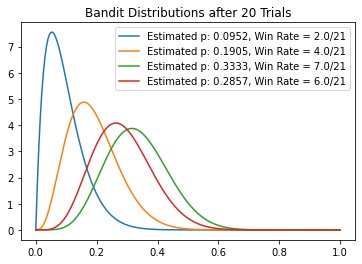

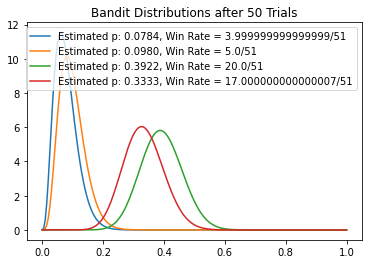

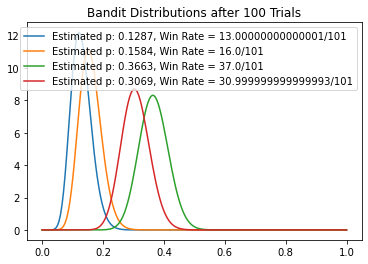

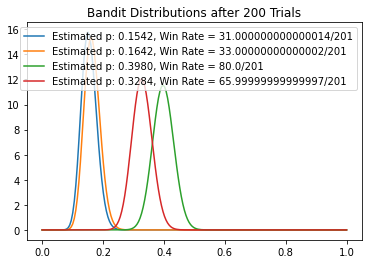

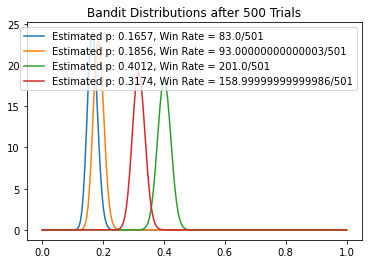

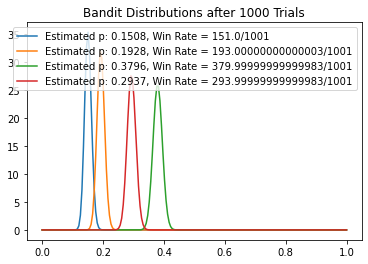

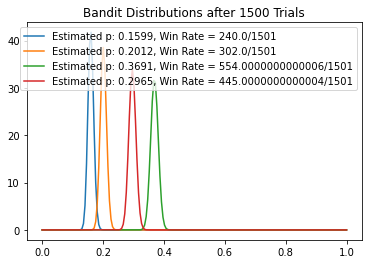

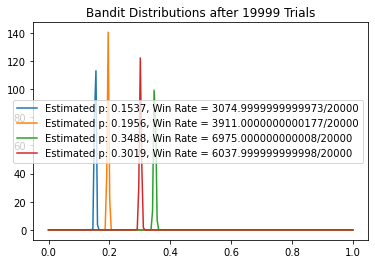

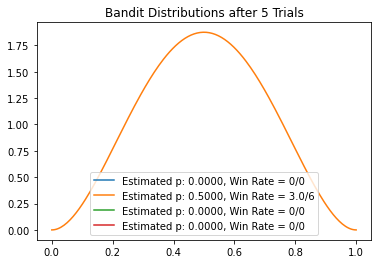

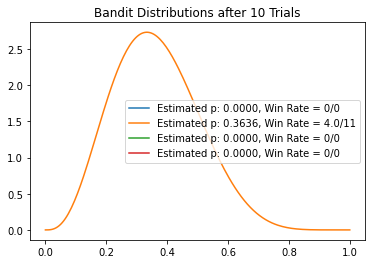

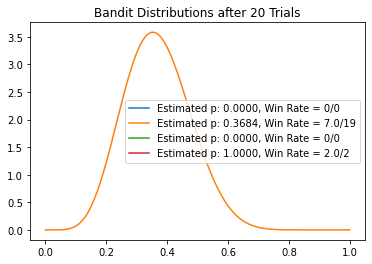

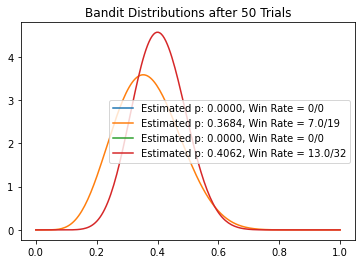

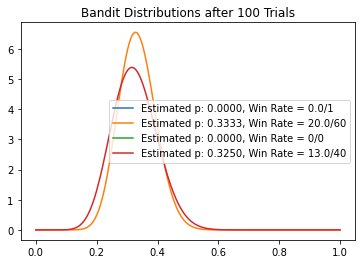

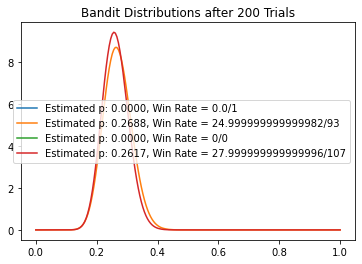

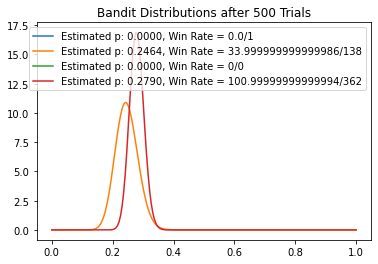

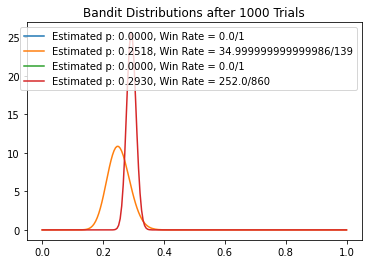

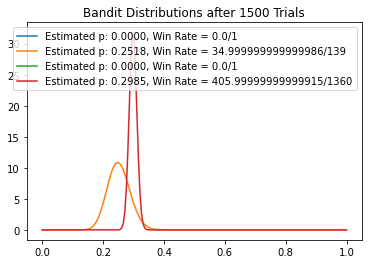

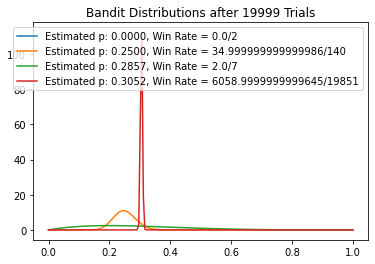

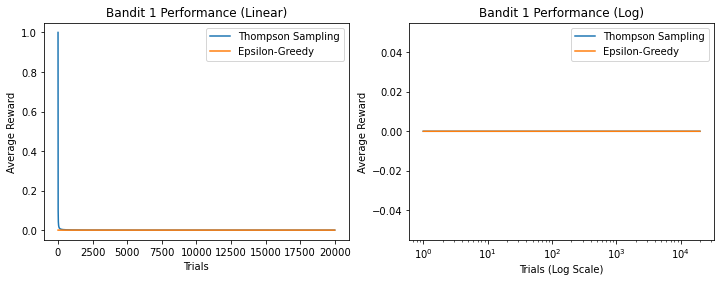

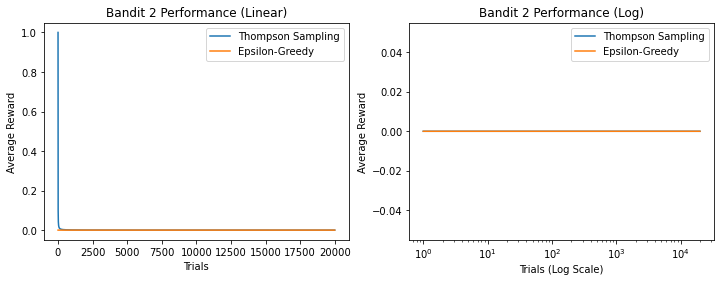

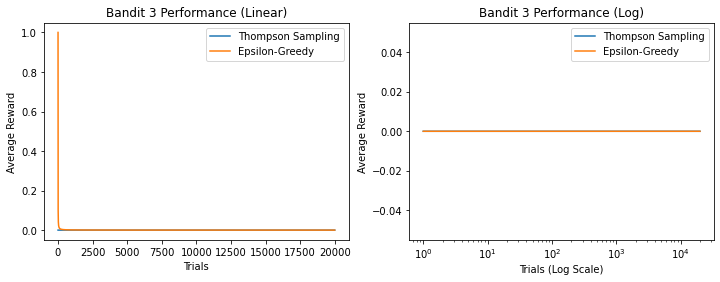

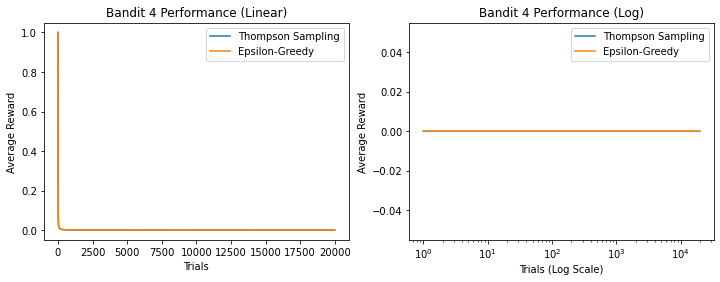

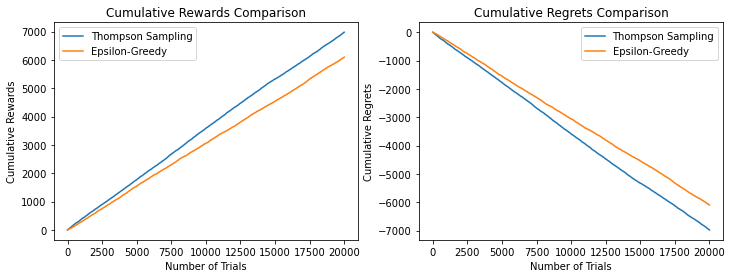

In [7]:
comparison()


From the graphs above, you can see how Cumulative Rewards for Thompson Sampling increased in a higher rate, this comes from the fundamental attributes of the Thompson Sampling algorithm and how, in the multi-armed bandit issue, it successfully maintains a balance between exploration and exploitation. And for the Cumulative Regrets, Thomspon Sampling decays in a higher rate, and this comes from the fact that Thompson Sampling is more effective in minimizing regret and making better decisions in the multi-armed bandit problem, compared Epsillion-Greedy.



\**NUMBERS and COLORS MENTIONED ABOVE ARE A SUBJECT TO CHANGE (coming from the fact of randomness in the algorithms).**

## *Bonus
Suggest better implementation plan

One of the common ways of improving the algorithm is Hyperparameter Tuning. It is a widespread practice in Machine learning, and not only. It is the process of deciding which machine learning algorithm hyperparameters to set to maximize the algorithm's performance for a given task. Hyperparameters such as epsilon (ε) for Epsilon-Greedy and the prior distributions for Thompson Sampling, when used in conjunction with bandit algorithms, can significantly affect the algorithm's performance. The process can be done manually, checking various hyperparameters, defining the one that gives the best results, or making a function that will do the same in a loop for a range of parameters. Thus, maybe using some algorithms to determine the best epsilon and probabilities for the Bandits can be helpful in a better implementation sense. 